In [1]:
### 単位面積あたりの賃料を予測する

In [48]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)


import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
from utils import save_data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
SEED=1234
n_splits=10

In [76]:
train=pd.read_csv('./input/prep_train1106.csv')
test=pd.read_csv('./input/prep_test1106.csv')
y_train = train['賃料']


In [77]:
# def get_Kmeans(X_train,X_test,n_clusters=300,cols=['loc_lat','loc_lon','築年数'],out_col='km_type_with_age'):
#     std=StandardScaler()
    
#     X = X_train[cols]
#     X2= X_test[cols]
#     Z=pd.concat([X,X2],axis=0)
#     Z=std.fit_transform(Z)

#     pred = KMeans(n_clusters=n_clusters).fit_predict(Z)
#     X_train[out_col]=pred[:X_train.shape[0]]
#     X_test[out_col]=pred[X_train.shape[0]:]
#     return X_train,X_test

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# train,test=get_Kmeans(train,test,n_clusters=840,cols=['loc_lat','loc_lon','築年数'],out_col='km_type_with_age840')

In [78]:
# train.to_csv('./input/prep_train1106.csv',index=None)
# test.to_csv('./input/prep_test1106.csv',index=None)

In [79]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [80]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

def target_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingをやる。func_listに辞書型で列と処理する関数(meanとか)を渡す'''
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

In [81]:
category_col='km_type_with_age'
X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}

for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '面積', func_list)
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '築年数', func_list)

target_dict = {category_col: ['mean','max','min','count']}
for category_col, func_list in target_dict.items():
    X_train, X_test = target_encoding(X_train, X_test, category_col, '地価', func_list)
    
X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']

X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']

In [82]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 100
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05

In [83]:
folder=KFold(n_splits=10, shuffle=True, random_state=421)

In [84]:
X_train_raw=X_train.copy()
X_test_raw=X_test.copy()

In [85]:
X_train=X_train_raw.copy()
X_test_=X_test_raw.copy()
features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階', '地価x面積', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio',
       'area/ageratio', '地価x面積/築年数ratio','1m2当たりの価格','鑑定評価額']+[col for col in X_train.columns if f'{category_col}_地価_' in col]
X_train = X_train[features]
X_test = X_test[features]

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 216.052	valid_1's rmse: 311.515
[10000]	training's rmse: 161.894	valid_1's rmse: 295.405
[15000]	training's rmse: 127.931	valid_1's rmse: 288.296
Early stopping, best iteration is:
[18859]	training's rmse: 108.915	valid_1's rmse: 285.457
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 216.587	valid_1's rmse: 301.884
[10000]	training's rmse: 162.876	valid_1's rmse: 288.782
[15000]	training's rmse: 129.809	valid_1's rmse: 283.173
Early stopping, best iteration is:
[19200]	training's rmse: 109.786	valid_1's rmse: 280.645
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 214.614	valid_1's rmse: 334.533
[10000]	training's rmse: 161.782	valid_1's rmse: 321.271
[15000]	training's rmse: 128.98	valid_1's rmse: 314.947
[20000]	training's rmse: 106.21	valid_1's rmse: 311.459
Early st

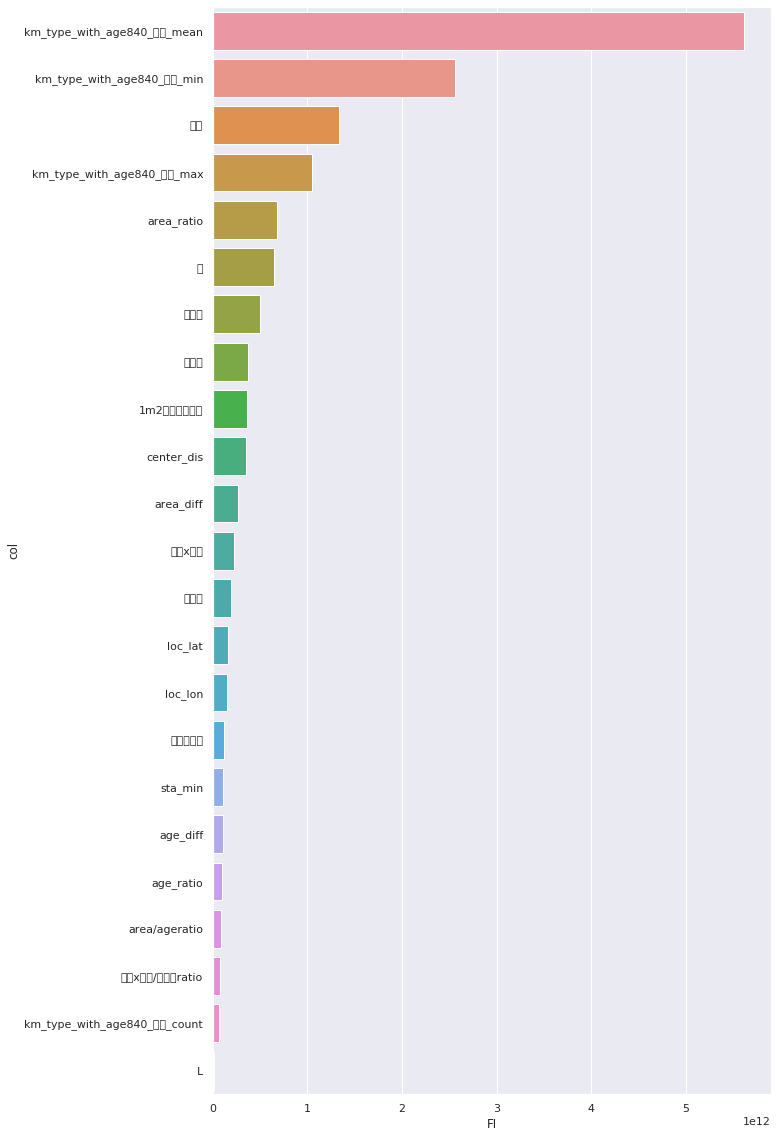

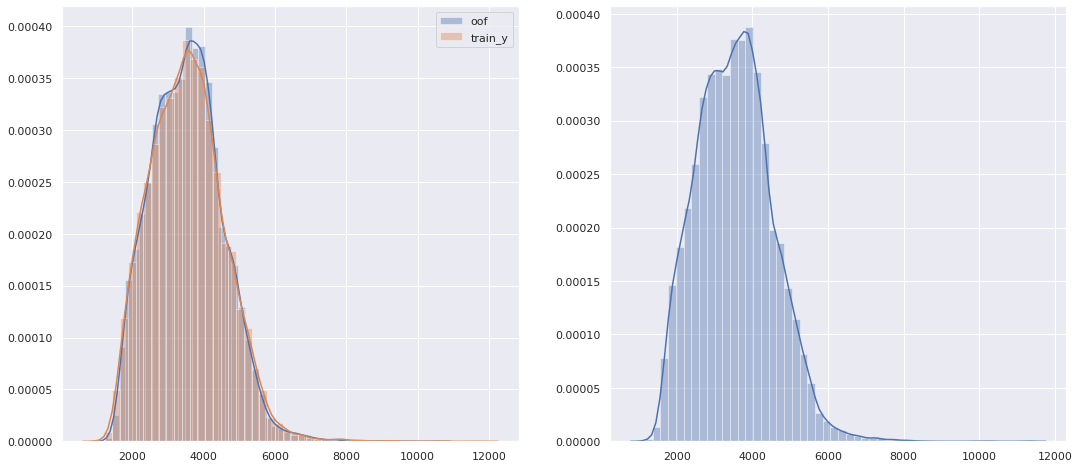

RMSE :  285.25316844042555
R^2 :  0.9179580531373328


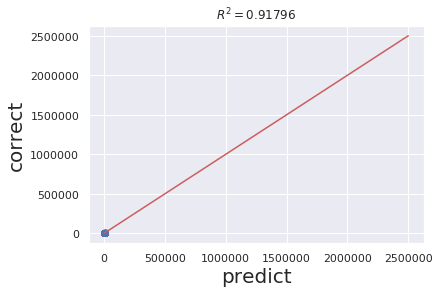

In [72]:
LGBM = RegressionPredictor(X_train, (y_train/X_train['面積']).values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()
LGBM.plot_scatter_oofvspred()

In [75]:
save_data(X_train,lgboof2, lgbpreds2,rmse=rmse,name='tika_PerArea840_TE05',save_dir='./stacking')

,id,target
0,31471,141301.879521
1,31472,118782.446962
2,31473,77241.504828
3,31474,63825.427367
4,31475,102401.527322


,id,target
0,1,78585.822701
1,2,67044.994824
2,3,109927.926115
3,4,177366.337234
4,5,70387.009992


RMSE :  14859.362107175873
R^2 :  0.9572674027759505


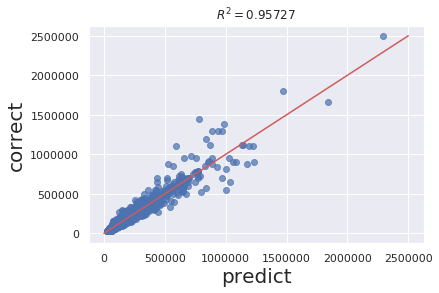

In [74]:
lgboof2=lgboof*X_train['面積']
lgbpreds2=lgbpreds*X_test['面積']
plot_scatter(lgboof2, y_train)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[5000]	training's l1: 0.017661	valid_1's l1: 0.0528706
[10000]	training's l1: 0.00811561	valid_1's l1: 0.0499923
[15000]	training's l1: 0.00464944	valid_1's l1: 0.0490346
[20000]	training's l1: 0.00306229	valid_1's l1: 0.0486435
[25000]	training's l1: 0.00223647	valid_1's l1: 0.0484409
Early stopping, best iteration is:
[29291]	training's l1: 0.00178868	valid_1's l1: 0.0483272
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[5000]	training's l1: 0.0176416	valid_1's l1: 0.0503928
[10000]	training's l1: 0.00818307	valid_1's l1: 0.0477989
[15000]	training's l1: 0.00465457	valid_1's l1: 0.0470279
[20000]	training's l1: 0.00306363	valid_1's l1: 0.0466674
[25000]	training's l1: 0.00222878	valid_1's l1: 0.0464503
Early stopping, best iteration is:
[25625]	training's l1: 0.00215159	valid_1's l1: 0.0464298
Training on fold 3
Training until validation scores don't improve for 100 r

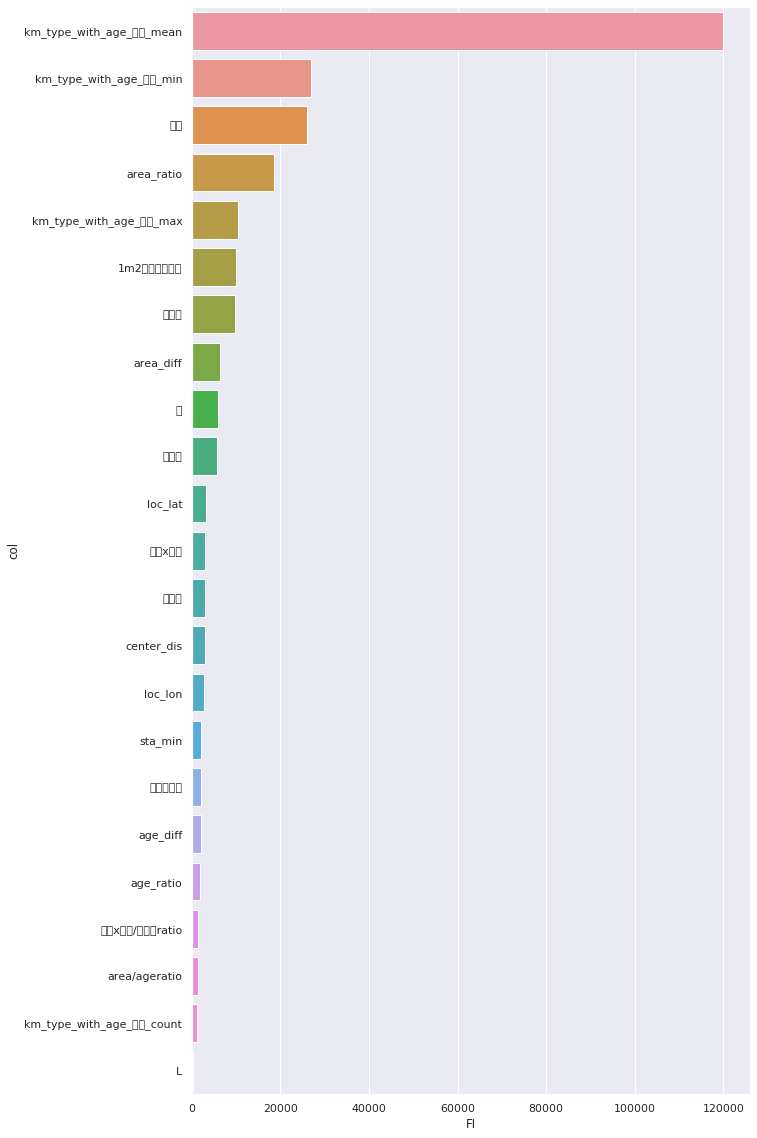

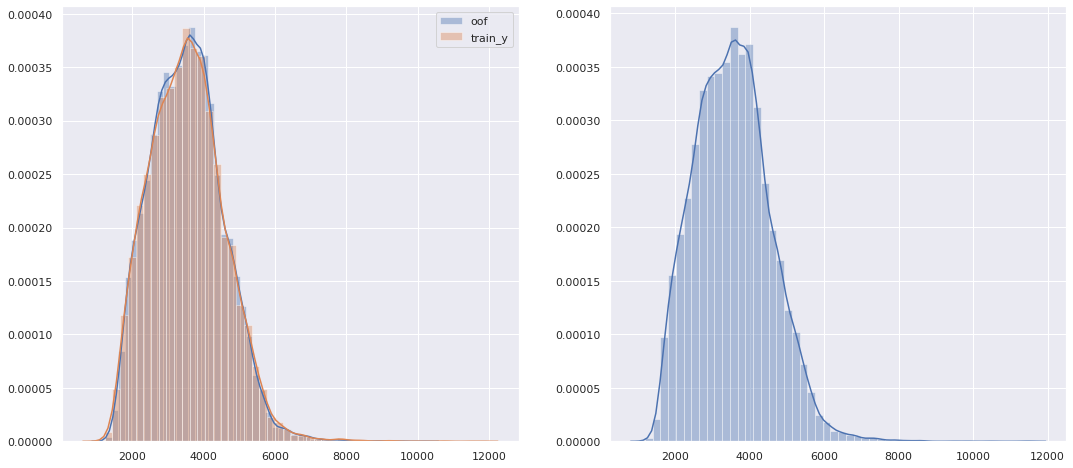

RMSE :  279.85852343409516
R^2 :  0.9226090065097934


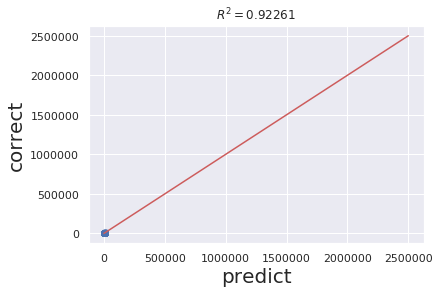

In [87]:
LogLGBM = LogRegressionPredictor(X_train, (y_train/X_train['面積']).values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()
LogLGBM.plot_scatter_oofvspred()


RMSE :  14487.822365766478
R^2 :  0.958754740244703


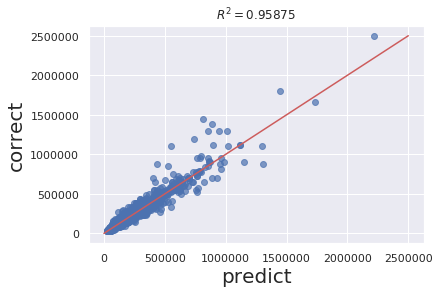

In [88]:
log_lgboof2=log_lgboof*X_train['面積']
log_lgbpreds2=log_lgbpreds*X_test['面積']
plot_scatter(log_lgboof2, y_train)

In [89]:
rmse=int(np.sqrt(mean_squared_error(log_lgboof2, y_train)))

In [90]:
save_data(X_train,log_lgboof2, log_lgbpreds2,rmse=rmse,name='log_tika_PerArea_TE_es100',save_dir='./stacking')

,id,target
0,31471,129636.023885
1,31472,119420.707169
2,31473,76025.693774
3,31474,64163.596842
4,31475,93743.426478


,id,target
0,1,75896.499348
1,2,67918.645350
2,3,109911.002544
3,4,168324.183447
4,5,70027.882387


In [138]:
oof1=pd.read_csv('./stacking/oof_14989_log_km_area_per_locmodified.csv',header=None)
oof2=pd.read_csv('./stacking/oof_15040_log_km_wa_locmodified.csv',header=None)

RMSE :  14989.476719352991
R^2 :  0.9557951350979206


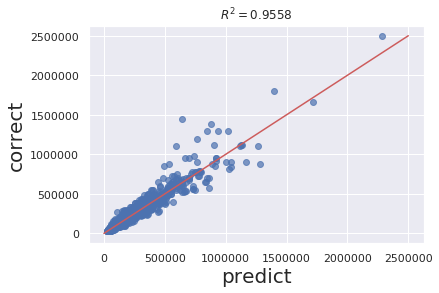

In [150]:
plot_scatter(oof1[1],y_train)